<a href="https://colab.research.google.com/github/shaharinv/ML-PROJECT-/blob/DL-PROJECTS/Cell_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Cell Segmentation and Denoising

---

# Objective
This Notebook will cover these practices on a cell/brain masked dataset :
- Segmentation of the cancerous cells or different sections of a tumour
- Denoising the

---


# Setup



In [ ]:
!pip install opencv-python --quiet
!pip install numba --quiet
!pip install tifffile --quiet
!pip install -q kaggle

In [ ]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests
import re
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split


from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

In [ ]:
# Helper functions
# By gemini
# prompt: write a helper function "im_show" to show images that are in format of tensor

def im_show(image, ax=None, figsize=(8, 8)):
  """Imshow for Tensor."""
  if ax is None:
    fig, ax = plt.subplots(figsize=figsize)
  # Handle 1-channel image
  if image.ndim == 2:
    image = image[..., None]
  ax.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
  ax.axis("off")
  return ax


# Getting the data
running this section once is enough since it's used to load data from kaggle

In [ ]:
!mkdir ./kaggle
!cp kaggle.json ./kaggle/
!chmod 600 ./kaggle/kaggle.json
!kaggle datasets download -d 'aryashah2k/breast-ultrasound-images-dataset'

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access './kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 97% 190M/195M [00:02<00:00, 65.8MB/s]
100% 195M/195M [00:02<00:00, 75.9MB/s]


In [ ]:
!unzip breast-ultrasound-images-dataset.zip -d ./data

Archive:  breast-ultrasound-images-dataset.zip
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: ./data/Dataset_BUSI_with_GT/benign/ben

# Loading the data
Since the image and the mask of the image is needed in the data segmentation process we had to write an specific dataset class for our data
Also an image can have more than one mask. In that case the masks have to be added into one mask image

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations > /dev/null 2>&1


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# part of this cell is generated by gemini
class BUSIDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.mask_paths = []
    for dirpath, _, filenames in os.walk(self.root_dir):
      for filename in filenames:
        if filename.endswith('.png'):
          if '_mask.png' in filename:
            self.mask_paths.append(os.path.join(dirpath, filename))
    self.mask_paths = sorted(self.mask_paths)

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, idx,):
    image =  cv2.imread(self.mask_paths[idx].replace('_mask', ''))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(self.mask_paths[idx])
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    #we might have more than one mask. in that case we gotto add em up
    mask_1 = cv2.imread(self.mask_paths[idx].replace('_mask', '_mask_1'))
    mask_2 = cv2.imread(self.mask_paths[idx].replace('_mask', '_mask_2'))

    if mask_1 is not None :
      mask_1 = cv2.cvtColor(mask_1,cv2.COLOR_BGR2GRAY)
      mask += mask_1
    if mask_2 is not None :
      mask_2 = cv2.cvtColor(mask_2,cv2.COLOR_BGR2GRAY)
      mask += mask_2

    if self.transform:
      image = self.transform(Image.fromarray(image))
      mask = self.transform(Image.fromarray(mask))

    return image, mask


torch.Size([1, 300, 300]) torch.Size([1, 300, 300])
Dataset size : 780


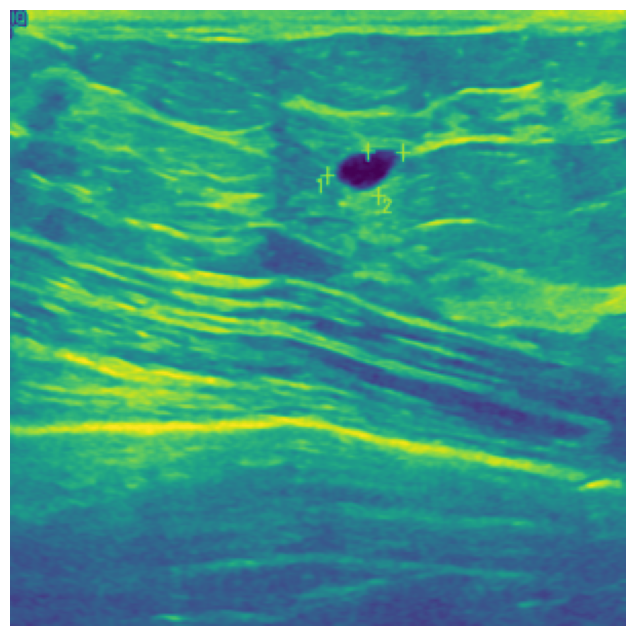

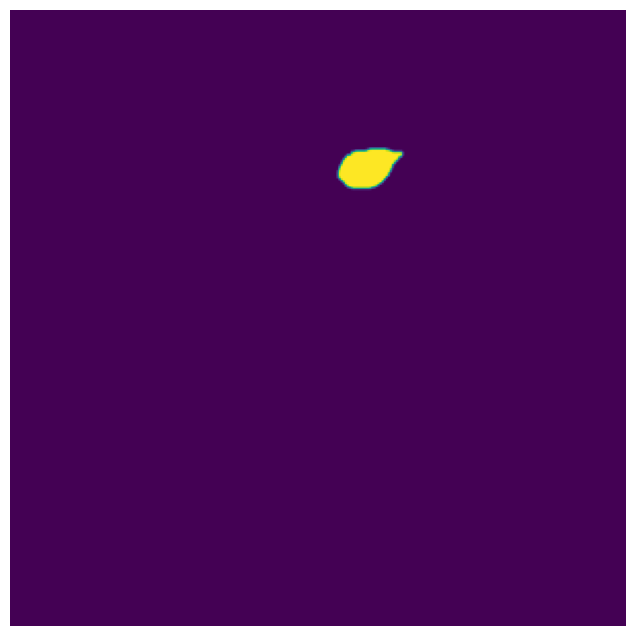

In [ ]:
# this transform instance resizes the width and height to make sure all the data is in one shape
# then it converts to tensor
# and finally normalizes the output
transform = transforms.Compose([transforms.Resize(size= (300,300)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.5], std = [0.2])])
dataset = BUSIDataset('./data/Dataset_BUSI_with_GT',transform = transform)
image, mask = dataset[12]
print(image.shape, mask.shape)
im_show(image)
im_show(mask)

img_all = [dataset[i][0] for i in range(len(dataset))]
msk_all = [dataset[i][1] for i in range(len(dataset))]

print(f"Dataset size : {len(dataset)}")

#WE SURELY LACK ENOUGH DATA
#NEED SOME DATA AUGMENTATION TECHNIQUES


#Data Augmentation

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 255, 308])


<Axes: >

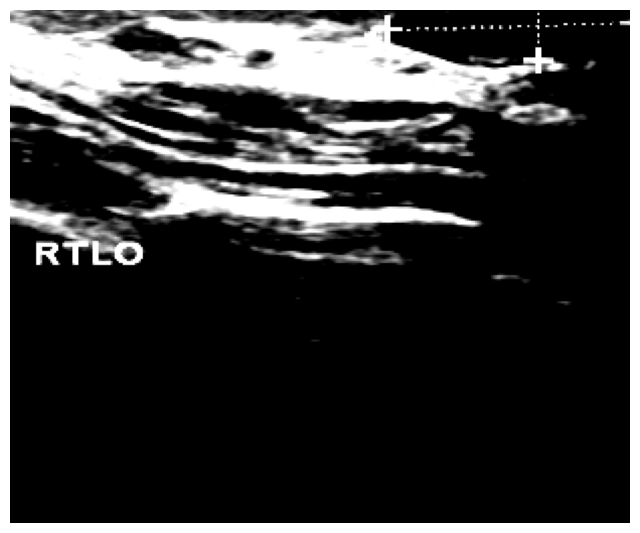

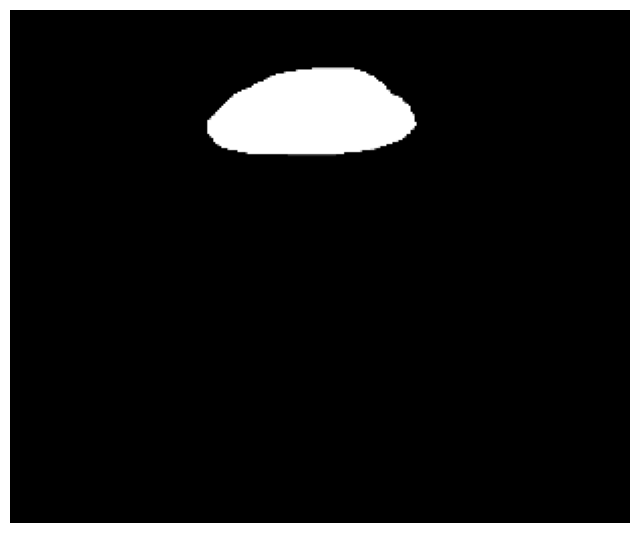

In [ ]:
aug_trf = v2.Compose([
    v2.RandomResizedCrop(size = (255,308),antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32,scale=True),
    v2.ToTensor(),
    v2.Normalize([0.5,0.5,0.5],[0.2,0.2,0.2])
])
aug_data = BUSIDataset('./data/Dataset_BUSI_with_GT',transform=aug_trf)
image,mask = aug_data[122]
print(image.shape)
im_show(image)
im_show(mask)

#Spliting Data

In [ ]:
seed = 42
train_ratio= 0.7
#create a generator object
gen = torch.Generator().manual_seed(42)
train_ds,val_ds = random_split(dataset,[train_ratio,(1 - train_ratio)])
img_train = torch.stack([train_ds[i][0] for i in range(len(train_ds))])
mask_train = torch.stack([train_ds[i][1] for i in range(len(train_ds))])
img_val = torch.stack([val_ds[i][0] for i in range(len(val_ds))])
mask_val = torch.stack([val_ds[i][1] for i in range(len(val_ds))])


In [ ]:
print(mask_train.shape)

torch.Size([546, 1, 300, 300])


In [ ]:
#LABELS :
labels_train = np.zeros((len(mask_train), 2,
                         mask_train.shape[-2],
                         mask_train.shape[-1]),
                        np.longlong)
print(labels_train.shape)
print((mask_train == 0 ).shape)
print(labels_train[:,0].shape)
labels_train[:, 0] = torch.squeeze(mask_train == 0)
labels_train[:, 1] = torch.squeeze(mask_train > 0)

labels_val = np.zeros((len(mask_val), 2,
                        mask_val.shape[-2],
                        mask_val.shape[-1]),
                       np.longlong)
labels_val[:, 0] = torch.squeeze(mask_val == 0)
labels_val[:, 1] = torch.squeeze(mask_val > 0)

(546, 2, 300, 300)
torch.Size([546, 1, 300, 300])
(546, 300, 300)


#U-net Architecture
Why U-net for biomedical Data :

1. Most of the time, in medical imaging, we do not have sufficient samples to train. Previous semantic segmentation architectures did not perform very well when trained on insufficient medical imaging samples (adapted from [here](https://debuggercafe.com/unet-from-scratch-using-pytorch/))
2.

the cells in this section are adapted from the template

In [ ]:
def convbatchrelu(in_channels, out_channels, sz):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    for n in range(len(nbase) - 1):
      self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels,
                                                 out_channels,
                                                 kernel_size))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size))

  def forward(self, x, y):
    x = self.conv[0](x)
    x = self.conv[1](x + y)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      if n > 0:
        x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 1 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0

  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

In [ ]:
kernel_size = 3
nbase = [1,8,64,128,256]  # number of channels per layer
nout = 3  # number of outputs

net = Unet(nbase, nout,kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

#Training the U-net

In [ ]:
#Hyperparameters :
batch_size = 8
n_epochs = 50
learn_rate = 0.1
#For L2 regularization :
weight_decay =1e-5
momentum = 0.9
n_epochs_per_save = 25


In [ ]:
num_of_lrs = 10
n_train = len(img_train)
#optimizer :
optimizer = torch.optim.SGD(net.parameters(),
                            lr = learn_rate,
                            momentum = momentum,
                            weight_decay = weight_decay,
                            )
lrs = np.linspace(0,learn_rate,num_of_lrs)

#Just in case num ofepochs are more than 250 :
if n_epochs > 250:
    Lrs = np.append(lrs, learn_rate*np.ones(n_epochs-100))
    for i in range(num_of_lrs):
        lrs = np.append(lrs, lrs[-1]/2 * np.ones(num_of_lrs))
else:
    lrs = np.append(lrs, learn_rate * np.ones(max(0, n_epochs - num_of_lrs)))

loss_criterion = nn.CrossEntropyLoss()

#loss for each epoch :
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

save_epoch = None

#looping over epochs :
for epoch in range(n_epochs):
  net.train()
  epoch_loss = 0
  iters =0
  for param_group in optimizer.param_groups :
    param_group['lr'] = lrs[epoch]


    with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='imgs') as pbar:

      for ith_batch in np.arange(0,n_train,batch_size):
        #Augmentation
        #left to be done
        imgs = img_train.to(device = device)
        lbls = torch.from_numpy(labels_train).to(device = device)
        #compute the loss
        y = net(imgs)
        loss = loss_criterion(y,lbls[:,1])
        epoch_loss += loss.item()
        pbar.set_postfix(**{'loss (batch)': loss.item()})
        #gradient_descent
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        iters +=1
        pbar.update(imgsshape[0])
      epoch_losses[epoch] = epoch_loss
      pbar.set_postfix(**{'loss (epoch)': epoch_loss})

  #Save stuff
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/50:   0%|          | 0/546 [00:00<?, ?imgs/s]